In [ ]:
#default_exp basic_operations_01

# Basic Operations

> Fundamental operations and helper functions in use throughout the library

In [ ]:
#export
#hide
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from nbdev.showdoc import show_doc

#the only torch import we will have in the project
from torch import tensor
import random
import pdb

_all_ = ["Path", "set_trace", "datasets", "pickle", "gzip", "math", "torch", "tensor", "random", "pdb", "show_doc"]

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

# Helper Functions

## Testing

In [ ]:
#export
def is_equal(a,b):
    "Test for equality between `a` and `b`"
    assert(a==b)

In [ ]:
#hide
path = datasets.download_data(MNIST_URL, ext='.gz'); path

with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [ ]:
#export
#hide
def near(a,b): 
    "Test if tensors `a` and `b` are the same within a small tolerance"
    return torch.allclose(a, b, rtol=1e-3, atol=1e-5)

In [ ]:
#export
def test_near(a,b): 
    "Test if tensors `a` and `b` are near within a small tolerance"
    if near(a,b) == True:
        print("good")
    else:
        print("not near")

In [ ]:
#export 
def test_near_zero(data, tol=1e-3):
    "Tests if tensor values are near zero under given 'tol'"
    assert data.abs() < tol; print(f'Near zero: {data}')

In [ ]:
test_near(torch.ones(2,2), torch.zeros(2,2))

not near


In [ ]:
test_near(torch.ones(2,2), torch.ones(2,2))

good


In [ ]:
test_near_zero(torch.zeros(2,2).mean())

Near zero: 0.0


## Data Loading

In [ ]:
#export
def normalize(datasets, mean=None, std=None):
    "Normalizes according to given 'mean' and 'std' or mean of std of datasets if none given"
    if mean is None: mean = datasets.mean()
    if std is None: std = datasets.std()
    return (datasets - mean) / std

In [ ]:
#export
def get_mnist():
    "Helper function to load `normalized` train and validation MNIST datasets"
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    
    xt,yt,xv,yv = map(tensor, (x_train, y_train, x_valid, y_valid))
    return normalize(xt).float(), yt.float(), normalize(xv, xt.mean(), xt.std()).float(), yv.float()

```python
def get_mnist():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    
    xt,yt,xv,yv = map(tensor, (x_train, y_train, x_valid, y_valid))
    return normalize(xt).float(), yt.float(), normalize(xv, xt.mean(), xt.std()).float(), yv.float()
```

In [ ]:
xt,yt,xv,yv = get_mnist()

In [ ]:
#export
def get_stats(data):
    "Print mean and standard deviation of given `data`"
    print (f'Mean: {data.mean()}')
    print (f'Std: {data.std()}')

In [ ]:
get_stats(xt)

Mean: 0.00012300178059376776
Std: 1.0


## Visualization

In [ ]:
#export
#hide
mpl.rcParams['image.cmap'] = 'gray'

In [ ]:
#export
def show_im(image, size=28):
    "Displays 'image' or random 'image' from set if multiple given of given 'size'"
    im_size = image.flatten().shape[0]
    if im_size > size**2:
        image = image[random.randint(0,math.floor((im_size-1)/size**2))]
    plt.imshow(image.view(size,size))

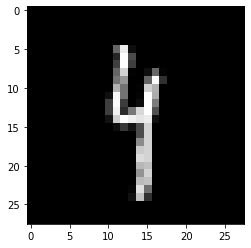

In [ ]:
show_im(x_train)

# Matmul

In [ ]:
#hide
test_weight = torch.randn(784, 10)
ims = x_train[:5]
ground_truth = ims @ test_weight

In [ ]:
#hide
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert (ac == br)
    c = torch.zeros(ar,bc)
    for bc_in in range(bc):
        for ar_in in range(ar):
            for ac_in in range(ac):
                c[ar_in][bc_in] += a[ar_in][ac_in]*b[ac_in][bc_in]
    
    return c

In [ ]:
#hide
%time c = matmul(ims,test_weight)

CPU times: user 699 ms, sys: 2.54 ms, total: 701 ms
Wall time: 702 ms


In [ ]:
#hide
test_near(c,ground_truth)

good


In [ ]:
#hide
def matmul2(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert (ac == br)
    c = torch.zeros(ar,bc)
    for bc_in in range(bc):
        for ar_in in range(ar):
                c[ar_in][bc_in] += (a[ar_in,:]*b[:,bc_in]).sum()
    
    return c

In [ ]:
#hide
%time c2 = matmul2(ims,test_weight)

CPU times: user 2.18 ms, sys: 959 µs, total: 3.14 ms
Wall time: 2.21 ms


In [ ]:
#hide
test_near(c2,ground_truth)

good


In [ ]:
#export
def matmul(a, b):
    "Perform matrix multiplication on `a` and `b`"
    ar, ac = a.shape
    br, bc = b.shape
    assert (ac == br)
    c = torch.zeros(ar,bc)
    for ar_in in range(ar):
        c[ar_in] += (a[ar_in].unsqueeze(-1) * b).sum(dim=0)
    
    return c

```python
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert (ac == br)
    c = torch.zeros(ar,bc)
    for ar_in in range(ar):
        c[ar_in] += (a[ar_in].unsqueeze(-1) * b).sum(dim=0)
    
    return c
```

In [ ]:
%time result = matmul(ims,test_weight)

CPU times: user 739 µs, sys: 583 µs, total: 1.32 ms
Wall time: 731 µs


In [ ]:
test_near(result,ground_truth)

good


In [ ]:
#hide
def matmul4(a,b): return a @ b

In [ ]:
#hide
%time c4 = matmul4(ims, test_weight)

CPU times: user 251 µs, sys: 154 µs, total: 405 µs
Wall time: 266 µs


In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted AdvancedTrainingLoop.ipynb.
Converted Convolutions and Pooling.ipynb.
Converted FullyConnectedNetwork.ipynb.
Converted ModelTraining.ipynb.
Converted basic_operations.ipynb.
Converted index.ipynb.
Converted tutorial.ipynb.
